# Symulacje komputerowe - raport

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

### __METODY REDUKCJI WARIANCJI__

![Zadanie3sym.PNG](<attachment:Zadanie3sym.PNG>)
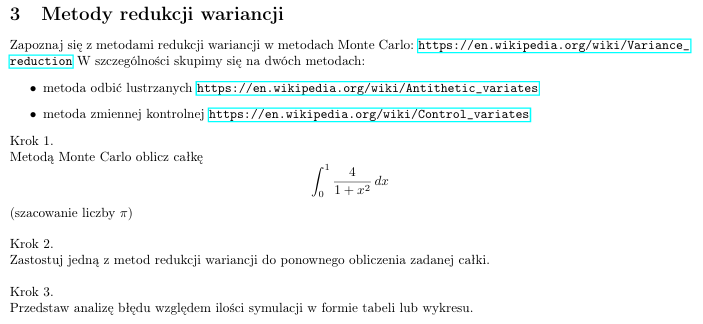

W zadaniu trzecim mamy wyszacować wartość liczby $ \pi $, licząc całkę $ \int_{0}^{1} \frac{4}{1 + x^2} \, dx $. Na pierwszy rzut oka możnaby zastanowić się co te dwie wartości mają do siebie, jednakże, gdy policzymy wartość zadanej całki oznaczonej wszystko staje się jasne.

$$
\int_{0}^{1} \frac{4}{1+x^2} \, dx = 4 \int_{0}^{1} \frac{1}{1+x^2} \, dx = 4 \left[ \arctan(x) \right]_{0}^{1} = 4 \left( \arctan(1) - \arctan(0) \right) = 4 \left( \frac{\pi}{4} - 0 \right) = \pi
$$

Wobec uzyskanego wyniku, w ramach zadania wyestymujemy wartość danej nam całki na trzy sposoby, a następnie porównamy wyniki i przede wszystkim dokładność tych estymacji. Pierwszy z nich to klasyczna metoda Monte Carlo, dwa pozostałe wykorzystują metody redukcji wariancji, o których więcej później. Zaczniemy jednak od implementacji czystego Monte Carlo w funkcji poniżej. Stworzona przez nas funkcja zwraca przybliżoną wartość całki funkcji **func** na przedziale od 0 do **x_lim**, policzonej przy pomocy metody Monte Carlo. Początkowo , tworza jest zmienna **count** zliczająca ile punktów, z **n** wygenerowanych, trafiło pod wykres funkcji **func**. Współrzędne punktu losowane są z rozkładu jednostajnego od 0 do **x_lim** dla współrzędnej X , a dla współrzędnej Y od 0 do **y_lim**. Na koniec funkcja zwraca oszacowną wartość naszej całki na zadanym przedziale według wzoru **x_lim\*y_lim\*count/n**.

In [2]:
def monte_carlo(func, x_lim, y_lim, n):
    # Inicjalizacja licznika punktów znajdujących się pod wykresem funkcji
    count = 0
    
    # Pętla wykonująca się n razy
    for i in range(int(n)):
        # Generowanie losowego punktu (X, Y) w prostokącie o wymiarach x_lim na y_lim
        X = np.random.uniform(0, x_lim)
        Y = np.random.uniform(0, y_lim)
        
        # Sprawdzenie, czy punkt (X, Y) znajduje się poniżej krzywej zadanej funkcją func
        if func(X) >= Y:
            # Jeśli punkt (X, Y) znajduje się poniżej krzywej, zwiększamy licznik
            count += 1
    
    # Obliczenie pola prostokąta i przemnożenie przez stosunek punktów poniżej krzywej do wszystkich punktów
    return (x_lim * y_lim * count / n)

Po implementacji klasycznej metody Monte Carlo przechodzimy do funkcji związanej z pierwszą z naszych metod redukcji wariancji - metody zmiennej kontrolnej. Estymacja ta różni się od klasycznego podejścia faktem, że oprócz oszacowania całki funkcji **func1**, obliczamy tą samą metodą całkę funkcji **func2** o znanej przez nas wartości **e**. Ostateczny estymator wartości całki, $\hat{\mu}_{X, Y}$, będzie wyglądać jak poniżej:

$$
\hat{\mu}_{X, Y} = \hat{\mu}_X + c(e - \hat{\mu}_Y),
$$
gdzie $\hat{\mu}_X$ to estymacja całki funkcji **func1**, $\hat{\mu}_Y$ to estymacja całki funkcji **func2**, $e$ to wspominana znana wartość całki funkcji **func2**, a $c$ jest policzone według wzoru

$$
c = -\frac{\text{Cov}(X, Y)}{\text{Var}(Y)}.
$$

Nasza funkcja **control_variates** zwraca przybliżoną wartość całki funkcji **func1** na przedziale od 0 do 1, przy pomocy opisanej powyżej metody. Na początku funkcja losuje próbkę długości **100*n**, aby obliczyć wartość współczynnika **c**. Następnie losowana jest już próbka długości **n**, służąca do ostatecznego oszacowania wartości całek. Wyliczone estymacje, obliczone **c** i zdane jako argument **e** podstawiane są do wzoru i na ich podstawie wyliczana oraz zwracana jest ostateczna wartość nowego estymatora.

In [3]:
def control_variates(func1, func2, e, n):
    # Generowanie dużego zestawu zmiennych losowych U1 o długości n*100
    U1 = np.random.uniform(0, 1, 100 * int(n))
    
    # Obliczanie wartości funkcji func1 i func2 dla zmiennych losowych U1
    f1 = func1(U1)
    g1 = func2(U1)
    
    # Obliczanie współczynnika c przy użyciu kowariancji i wariancji
    c = -np.cov(f1, g1, ddof=1)[0, 1] / np.var(g1)
    
    # Generowanie nowego zestawu zmiennych losowych U2
    U2 = np.random.uniform(0, 1, int(n))
    
    # Obliczanie średnich wartości func1(U2) i func2(U2)
    f2 = np.mean(func1(U2))
    g2 = np.mean(func2(U2))
    
    # Zwracanie wartości estymowanej funkcji func1 z uwzględnieniem zmiennej kontrolnej func2
    return f2 - c * (g2 - e)

Drugą z metod redukcji wariancji jest metoda odbić lustrzanych. Wygląda ona bardzo podobnie do klasycznego Monte Carlo, różni ją jednak fakt, że w momencie wylosowania współrzędnej X dla punktu obliczamy współrzędną X drugiego punktu, która jest równa wartości różnicy między **x_lim**, a wylosowaną wcześniej współrzędną. Otrzymujemy w ten sposób dwa razy więcej punktów, niż w oryginalnym Monte Carlo, co pozwala nam wydatnie poprawić nasze szacunki. Nasza funkcja **antithetic_variates**, identycznie jak funkcja **monte_carlo**, zwraca przybliżoną wartość pola pod wykresem funkcji **func** na przedziale od 0 do x_lim, na podstawie ilości punktów, które trafiły pod krzywą, zliczonych przy pomocy zmiennej **count**. W pętli **n** razy losowana jest zmienna X z rozkładu jednostajnego od 0 do **x_lim**, obliczana zmienna **X_anti** równa **x_lim - X** i ostatecznie losowana zmienna Y z rozkładu jednostajnego od 0 do **y_lim**. Za każdy z dwóch powstałych w ten sposób punktów, znajdujących się pod wykresem funkcji **func**, do zmiennej **count** dodawane jest jeden. Po zakończeniu pętli zwracana jest estymacja obliczona według wzoru **x_lim\*y_lim\*count/(2*n)**, gdzie dzielenie przez 2 wynika z dwa razy większej liczby sprawdzanych punktów.

In [4]:
def antithetic_variates(func, x_lim, y_lim, n):
    # Inicjalizacja licznika punktów znajdujących się pod wykresem funkcji
    count = 0

    # Pętla wykonująca się n razy
    for i in range(int(n)):
        # Generowanie losowego punktu (X, Y) w prostokącie o wymiarach x_lim na y_lim i obliczenie wartości X_anti
        X = np.random.uniform(0,x_lim)
        X_anti = x_lim-X
        Y = np.random.uniform(0,y_lim)

        # Sprawdzenie, czy punkty (X, Y) i (X_anti, Y) znajdują się poniżej krzywej zadanej funkcją func
        if func(X) >= Y:
            # Jeśli punkt (X, Y) znajduje się poniżej krzywej, zwiększamy licznik
            count += 1
        if func(X_anti) >= Y:
            # Jeśli punkt (X_anti, Y) znajduje się poniżej krzywej, zwiększamy licznik
            count += 1

    # Obliczenie pola prostokąta i przemnożenie przez stosunek punktów poniżej krzywej do wszystkich punktów
    return(x_lim*y_lim*count/(2*n))

Po implementacji wszystkich testowanych metod możemy przejść do porównania jak radzą sobie one z szacowaniem liczby $\pi$.

Błąd czystego Monte Carlo: 0.02084918065054519
Błąd Monte Carlo z metodą zmiennej kontrolnej: 0.0158428885813599
Błąd Monte Carlo z metodą odbić lustrzanych: 0.015853343923843372


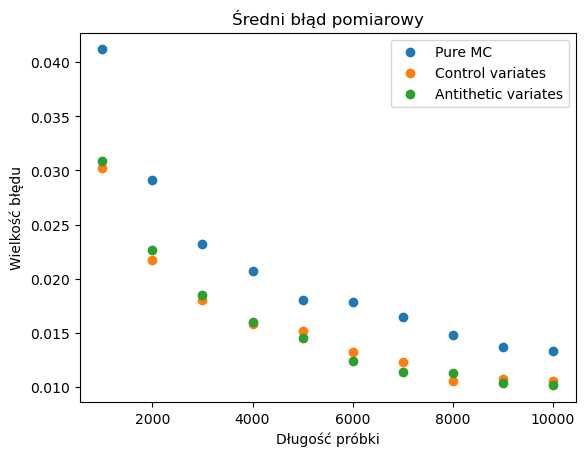

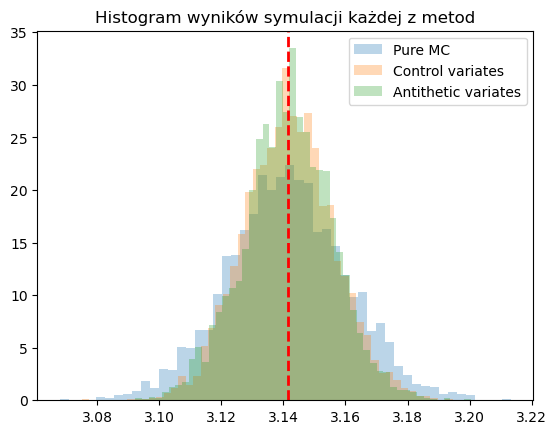

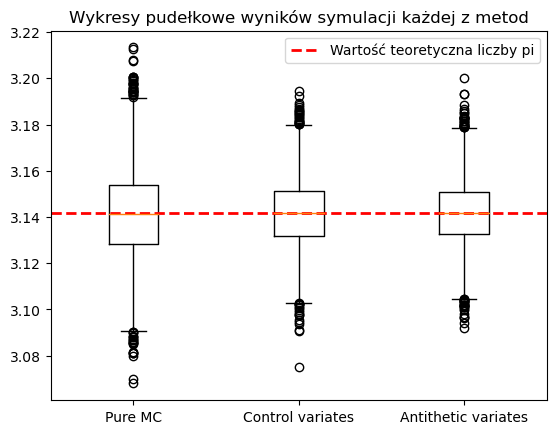

In [14]:
N = np.linspace(1000, 10000, 10)
errorsMC = [] #średni błąd czystego Monte Carlo
errorsCV = [] #średni błąd Monte Carlo z metodą zmiennej kontrolnej
errorsAV = [] #średni błąd Monte Carlo z metodą odbić lustrzanych
resultsMC = [] #wyniki pojedynczych symulacji czystego Monte Carlo dla n>5000
resultsCV = [] #wyniki pojedynczych symulacji Monte Carlo z metodą zmiennej kontrolnej dla n>5000
resultsAV = [] #wyniki pojedynczych symulacji  Monte Carlo z metodą odbić lustrzanych dla n>5000
integral = lambda x: 4/(1+x**2)
den = lambda x: 1+x**2
e = 4/3
x_max = 1
y_max = 4
k = 1000

for n in N:
    MC = 0
    CV = 0
    AV = 0
    for j in range(k):
        resultMC = monte_carlo(integral, x_max, y_max, n)
        resultCV = control_variates(integral, den, e, n)
        resultAV = antithetic_variates(integral, x_max, y_max, n)
        MC += abs(np.pi-resultMC)
        CV += abs(np.pi-resultCV)
        AV += abs(np.pi-resultAV)
        if int(n) > 5000:
            resultsMC.append(resultMC)
            resultsCV.append(resultCV)
            resultsAV.append(resultAV)
    errorsMC.append(MC/k)
    errorsCV.append(CV/k)
    errorsAV.append(AV/k)

print("Błąd czystego Monte Carlo:", np.mean(errorsMC))
print("Błąd Monte Carlo z metodą zmiennej kontrolnej:", np.mean(errorsCV))
print("Błąd Monte Carlo z metodą odbić lustrzanych:", np.mean(errorsAV))

plt.scatter(N,errorsMC, label = "Pure MC")
plt.scatter(N,errorsCV, label = "Control variates")
plt.scatter(N,errorsAV, label = "Antithetic variates")
plt.legend(loc = "best")
plt.title("Średni błąd pomiarowy")
plt.xlabel("Długość próbki")
plt.ylabel("Wielkość błędu")
plt.show()

plt.hist(resultsMC, label = "Pure MC", alpha = 0.3, bins = 50, density = True)
plt.hist(resultsCV, label = "Control variates", alpha = 0.3, bins = 50, density = True)
plt.hist(resultsAV, label = "Antithetic variates", alpha = 0.3, bins = 50, density = True)
plt.legend(loc = "best")
plt.title("Histogram wyników symulacji każdej z metod")
plt.axvline(x=np.pi, color='r', linestyle='--', linewidth=2, label='Wartość teoretyczna liczby pi')
plt.show()

fig, ax = plt.subplots()
boxplot_data = [resultsMC, resultsCV, resultsAV]
ax.boxplot(boxplot_data)
ax.set_xticklabels(["Pure MC", "Control variates", "Antithetic variates"])
ax.axhline(y=np.pi, color='r', linestyle='--', linewidth=2, label='Wartość teoretyczna liczby pi')
plt.legend(loc = "best")
plt.title("Wykresy pudełkowe wyników symulacji każdej z metod")
plt.show()

Jak widać zarówno po samych wartościach średniego błędu każdej symulacji, jak i po wykresach punktowym, histogramie i pudełkowych, metody redukcji wariancji wydatnie pomagają nam się zbliżyć do wartości teoretycznej $\pi$, względem czystej metody Monte Carlo. Tak naprawdę skuteczność metody zmiennej kontrolnej, jak i metody odbić lustrzanych, są bardzo do siebie zbliżone i ciężko stwierdzić, która z tych dwóch jest lepsza. Szczególnie dobrze widać zmniejszenie się wariancji na wykresie pudełkowym, gdzie dla metod redukcji wariancji wykresy rozciągają się na mniejszej rozpiętości na osi OY niż wykres dla oryginalnego Monte Carlo. Ponadto na histogramie wyników widać jak Monte Carlo, bez metod redukcji wariancji,  daje wiele estymacji znajdujących się daleko od wartości rzeczywistej liczby pi - niebieski histogram blisko rzeczywistej wartości jest niższy, niż pozostałe dwa, a im dalej od rzeczywistej wartości zaczyna się wybijać nad pozostałe dwa. Zwykły wykres punktowy z kolei pokazuje jak wraz ze wzrostem liczby próbek n, maleje błąd każdego z algorytmów, ale także utrzymującą się przewagę metod redukcji wariancji nad czystym Monte Carlo.

### __PRAWA ARCUSA SINUSA__

![Zadanie6sym.PNG](<attachment:Zadanie6sym.PNG>)
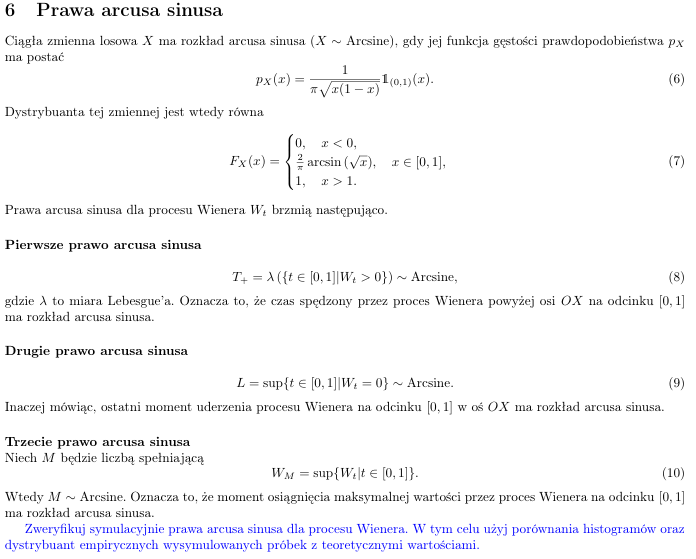

W ostatnim z zadań mamy symulacyjnie sprawdzić prawdziwość praw arcusa sinusa dla procesu Wienera. Zaczniemy wobec tego od implementacji samego procesu Wienera, inspirując się implementacją n-wymiarowego ruchu Browna, przedstawioną na naszych zajęciach. Stworzona funkcja **wiener_process** gneruje trajektorię procesu Wienera, zaczynając od stworzenia wektora czasu od 0 do **T**, podzielonego równomiernie na odcinki o długości **dt**. Następnie tworzona jest zmienna **X**, będąca listą z elementem 0, która będzie przechowywać położenie naszej cząstki w kolejnych krokach. Następnie w pętli o długości listy wektora czasowego - 1, dodawane są kolejne elementy do listy **X**, równe sumie aktualnego ostatniego elementu listy z liczbą wygenrowaną z rozkładu normalnego o średniej 0 i wariancji **dt**. Na koniec zwracana jest trajektoria procesu, jako lista.

In [9]:
def wiener_process(dt,T):
    # Inicjalizacja wektora czasowego i obliczenie jego długości
    Time = np.linspace(0,T,int(np.ceil(T/dt)))
    l = len(Time)

    # Stworzenie listy z trajekotorią procesu Wienera, zaczynającą się w 0
    X = [0]

    # Dodawanie w pętli kolejnych położeń cząstki podczas procesu Wienera
    for i in range(1,l):
        # Obliczenie i dodanie kolejnego położenia do listy
        X.append(X[-1]+np.random.normal(0,dt))

    # Zwrot trajektorii procesu Wienera
    return(X)

W kolejnym kroku, po kluczowej implementacji, stworzymy zmienne potrzebne nam do weryfikacji każdego z trzech praw, takie jak funkcje teoretyczne gęstości i dystrybuanty rozkładu arcusa sinusa czy liczba **n**, oznaczająca ile razy będziemy symulować proces Wienera. Wspomniana gęstość rozkładu arcusa sinusa jest dana wzorem 

$$
p_{X}(x)=\frac{1}{\pi\sqrt{x(1-x)}}𝟙_{(0,1)}(x).
$$
Dystrybuanta tego rozkładu z kolei wygląda jak poniżej

$$ 
F_{X}(x)=
\begin{cases} 
      0, & x< 0, \\
      \frac{2}{\pi}arcsin(\sqrt{x}), & x \in [0,1], \\
      1, & x>1.
\end{cases}
$$

In [10]:
n = 10000
x_list = np.linspace(0, 1, 10000)
gestosc = lambda x: 1/(np.pi*np.sqrt(x*(1-x)))
dystrybuanta = lambda x: (2/np.pi)*np.arcsin(np.sqrt(x))

W tym momencie jesteśmy w stanie zacząć weryfikowanie prawdziwości poszczególnych praw arcusa sinusa dla procesu Wienera. Pierwsze z nich prezentuje sie w następujący sposób

$$
T_{+}=\lambda({t\in[0,1]|W_{t}>0}) \sim Arcsine,
$$

gdzie $\lambda$, to miara Lebesgue'a. Wzór ten oznacza, że czas spędzony powyżej osi $OX$, na odcinku $[0,1]$, przez proces Wienera ma rozkład arcusa sinusa.

C:\Users\Dell\AppData\Local\Temp\ipykernel_3484\3646481970.py:3: RuntimeWarning: divide by zero encountered in true_divide
  gestosc = lambda x: 1/(np.pi*np.sqrt(x*(1-x)))


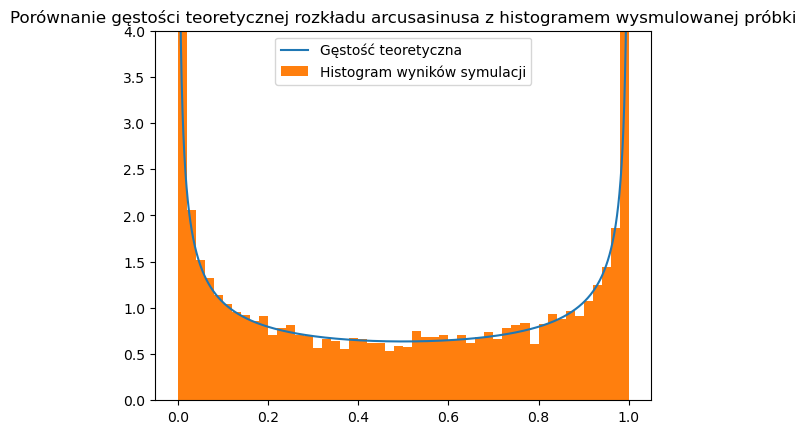

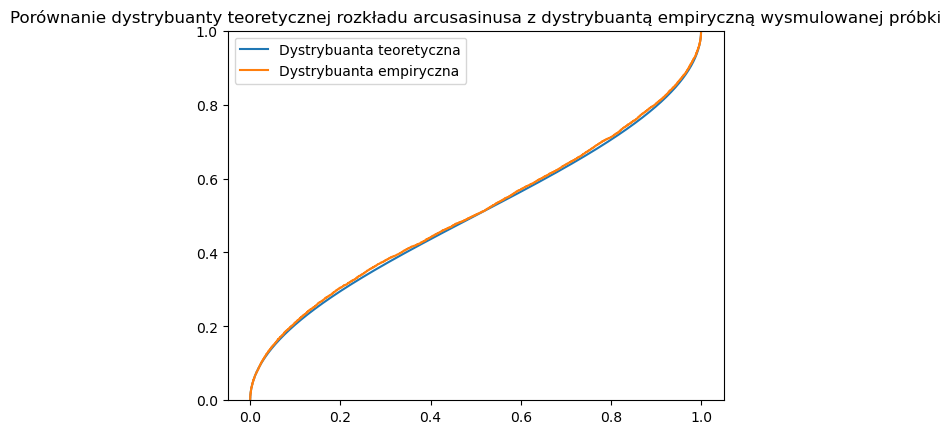

In [11]:
time = []

for i in range(n):
    sample = wiener_process(1/n, 1)
    count = 0 #zmienna zliczająca ile kroków proces Wienera spędził powyżej 0
    for j in sample:
        if j > 0:
            count += 1
    time.append(count/n)

plt.plot(x_list, gestosc(x_list), label = "Gęstość teoretyczna")
plt.hist(time, bins = 50, density = True,  label = "Histogram wyników symulacji")
plt.title("Porównanie gęstości teoretycznej rozkładu arcusasinusa z histogramem wysmulowanej próbki")
plt.ylim(0, 4)
plt.legend(loc="best")
plt.show()

plt.plot(x_list, dystrybuanta(x_list), label = "Dystrybuanta teoretyczna")
sns.ecdfplot(time, label = "Dystrybuanta empiryczna")
plt.title("Porównanie dystrybuanty teoretycznej rozkładu arcusasinusa z dystrybuantą empiryczną wysmulowanej próbki")
plt.legend(loc="best")
plt.ylabel("")
plt.show()

Jak widać zarówno porównane gęstość i histogram, a także dystrybuanty teoretyczna i empiryczna, przyjmują bardzo podobne kształty. Na tej podstawie możemy z dużą dozą pewności stwierdzić, że badana zmienna losowa ma rozkład arcus sinusa. Teraz sprawdzimy drugie prawo

$$
L=\sup\{t\in[0,1]|W_{t}=0\} \sim Arcsine,
$$
mówiące, że ostatni moment uderzenia procesu Wienera w oś $OX$ na odcinku $[0,1]$ ma rozkład arcusa sinusa.

C:\Users\Dell\AppData\Local\Temp\ipykernel_3484\3646481970.py:3: RuntimeWarning: divide by zero encountered in true_divide
  gestosc = lambda x: 1/(np.pi*np.sqrt(x*(1-x)))


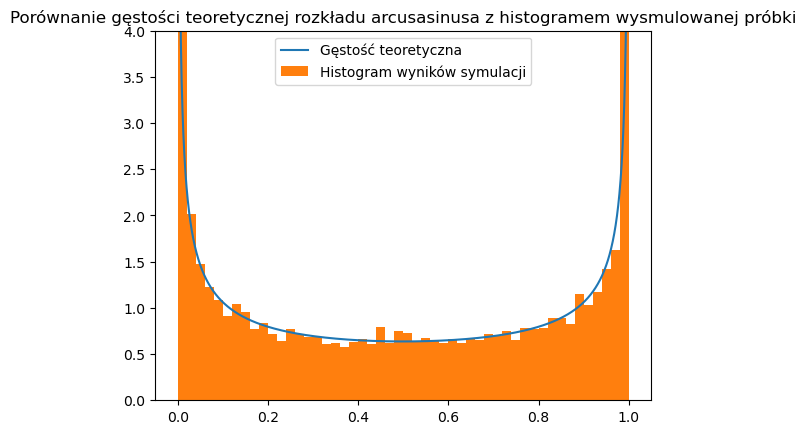

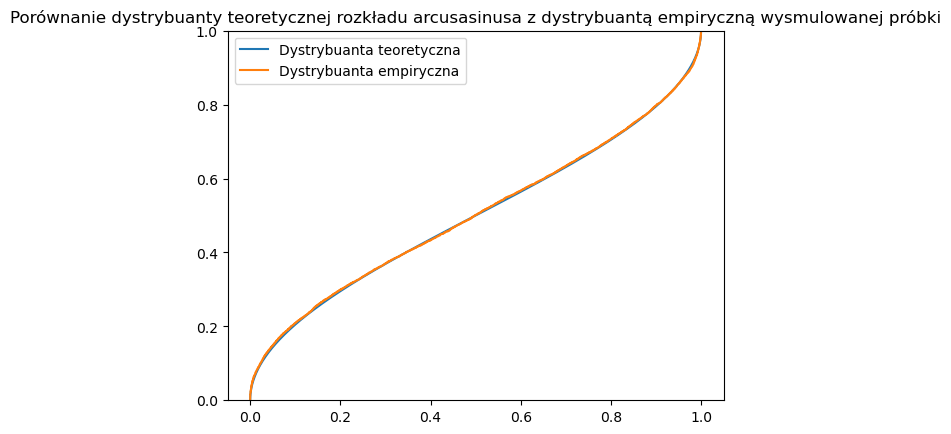

In [12]:
last = []

for i in range(n):
    sample = wiener_process(1/n, 1)
    hit = 0
    
    for j in range(1, len(sample)):
        if sample[j-1]*sample[j] < 0:
            hit = j/n #zmienna równa ostatniemu momentowi uderzenia procesu Wienera w oś OX
    last.append(hit)

plt.plot(x_list, gestosc(x_list), label = "Gęstość teoretyczna")
plt.hist(last, bins = 50, density = True,  label = "Histogram wyników symulacji")
plt.title("Porównanie gęstości teoretycznej rozkładu arcusasinusa z histogramem wysmulowanej próbki")
plt.ylim(0, 4)
plt.legend(loc="best")
plt.show()

plt.plot(x_list, dystrybuanta(x_list), label = "Dystrybuanta teoretyczna")
sns.ecdfplot(last, label = "Dystrybuanta empiryczna")
plt.title("Porównanie dystrybuanty teoretycznej rozkładu arcusasinusa z dystrybuantą empiryczną wysmulowanej próbki")
plt.legend(loc="best")
plt.ylabel("")
plt.show()

Tutaj, podobnie jak w przypadku pierwszego z praw, wykresy udowadniają, że ta zmienna również ma rozkład arcusa sinusa. Wobec tego przyszedł czas na ostatnie, trzecie, prawo

$$
W_{M}=sup\{W_{t}|t\in[0,1]\},
$$

stanowiące, że $M \sim Arcsine$, gdy spełnia powyżse równanie. Słwonie, moment osiągnięcia maksymalnej wartości przez proces Wienera na odcinku $[0,1]$ przyjmuje rozkład arcusa sinusa.

C:\Users\Dell\AppData\Local\Temp\ipykernel_3484\3646481970.py:3: RuntimeWarning: divide by zero encountered in true_divide
  gestosc = lambda x: 1/(np.pi*np.sqrt(x*(1-x)))


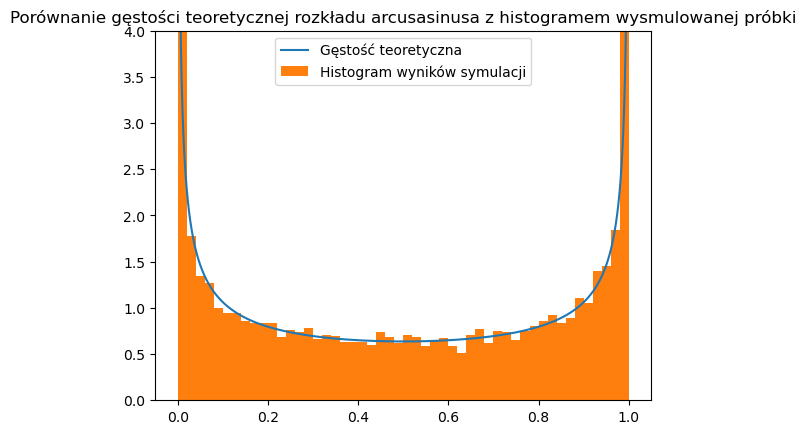

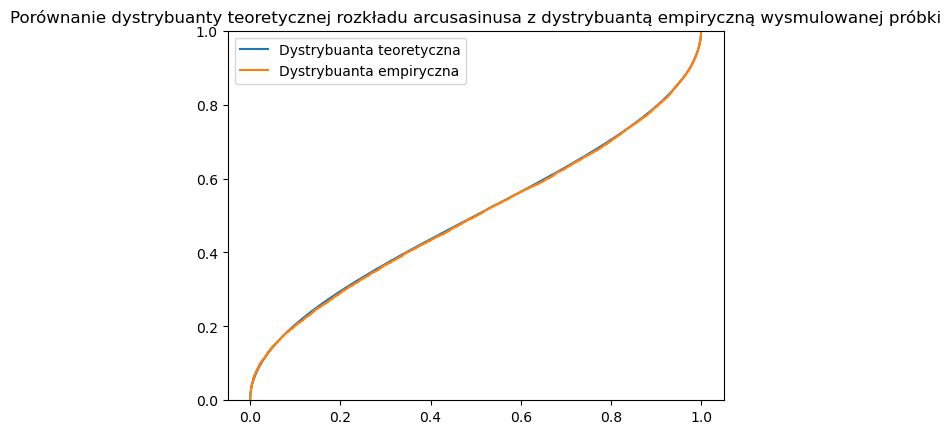

In [13]:
maximum = []

for i in range(n):
    sample = wiener_process(1/n, 1)
    maximum.append(sample.index(max(sample))/n) #zmienna równa momentowi osiągniecia maksymalnej wartości przez proces Wienera

plt.plot(x_list, gestosc(x_list), label = "Gęstość teoretyczna")
plt.hist(maximum, bins = 50, density = True,  label = "Histogram wyników symulacji")
plt.title("Porównanie gęstości teoretycznej rozkładu arcusasinusa z histogramem wysmulowanej próbki")
plt.ylim(0, 4)
plt.legend(loc="best")
plt.show()

plt.plot(x_list, dystrybuanta(x_list), label = "Dystrybuanta teoretyczna")
sns.ecdfplot(maximum, label = "Dystrybuanta empiryczna")
plt.title("Porównanie dystrybuanty teoretycznej rozkładu arcusasinusa z dystrybuantą empiryczną wysmulowanej próbki")
plt.legend(loc="best")
plt.ylabel("")
plt.show()

Spodziewanie, porównanie histogramu próbki i gęstości teoretycznej oraz dystrybuanty teoretycznej i empirycznej pozwala nam stwierdzić, że również trzecie prawo arcus sinusa dla procesu Wienera jest prawdziwe.